### Note - custom version of pandas needed

In [1]:
import glob

import numpy as np
from scipy import optimize as op
import matplotlib.pyplot as plt

from bts_phot import calibrate_fps

%matplotlib notebook

# ZTF fps

The IPAC forced photometry service (fps) produces fixed-position, "forced" photometry on existing difference images in the ZTF IPAC archive. The [IPAC fps documentation](http://web.ipac.caltech.edu/staff/fmasci/ztf/forcedphot.pdf) includes all the relevant details, here we provide a brief summary of the fps before describing the BTS light curve processing procedure.

 The fps takes a user-supplied position (and date range) and queries the ZTF subtraction image database for all images that contain the specified coordinates. PSF photometry is then measured at the specified position using the already-determined PSF model for the subtraction image. Results from these measurements are then returned in a standard IPAC table. There are many columns in the table, some of which are useful for flagging unreliable flux measurements, but the most important columns are: `jd`, `filter`, `zpdiff`, `forcediffimflux`, and `forcediffimfluxunc`.

While the fps provides both a zero-point and flux measurement, potential systematic offsets in the gain of the reference and new science images requires correction prior to measuring a calibrated flux. 

# BTS light curves

IPAC fps output requires a "baseline correction" ([see the docs](http://web.ipac.caltech.edu/staff/fmasci/ztf/forcedphot.pdf)). This baseline is best determined using a large (>~ 25) statistical sample of subtraction images that do not include emission from the transient of interest. Most transients have a suitable set of "pre-transient" images, but a significant fraction (e.g., many ZTF discoveries from 2018) require images taken long after the transient has faded. A suitable baseline can be identified visually, though with thousands of BTS transients we automate this procedure.

### Flagging unreliable observations

We attempt to flag observations that are not reliable, in case users wish to remove these from their analysis. For the most part, such images were taken in extremely poor observing conditions and it was not possible to properly calibrate the PSF model. In particular, we flag images that match the following criteria as `poor_conditions` within the data products: 

1. `infobits` > 0
2. `scisigpix` > 25
3. `sciinpseeing` > 5

(see [Yao et al. (2019)](http://dx.doi.org/10.3847/1538-4357/ab4cf5) for further details). A non-zero value for `infobits` typically indicates a problem with the IPAC data processing pipeline. `infobits` > 33554432 corresponds to "cloudy" data (see Section 2.4 of the [ZTF Science Data System (ZSDS) Advisories & Cautionary Notes](http://web.ipac.caltech.edu/staff/fmasci/ztf/extended_cautionary_notes.pdf)). 

Note that observations that have been flagged as unreliable are excluded from any baseline calculations.

<IPython.core.display.Javascript object>


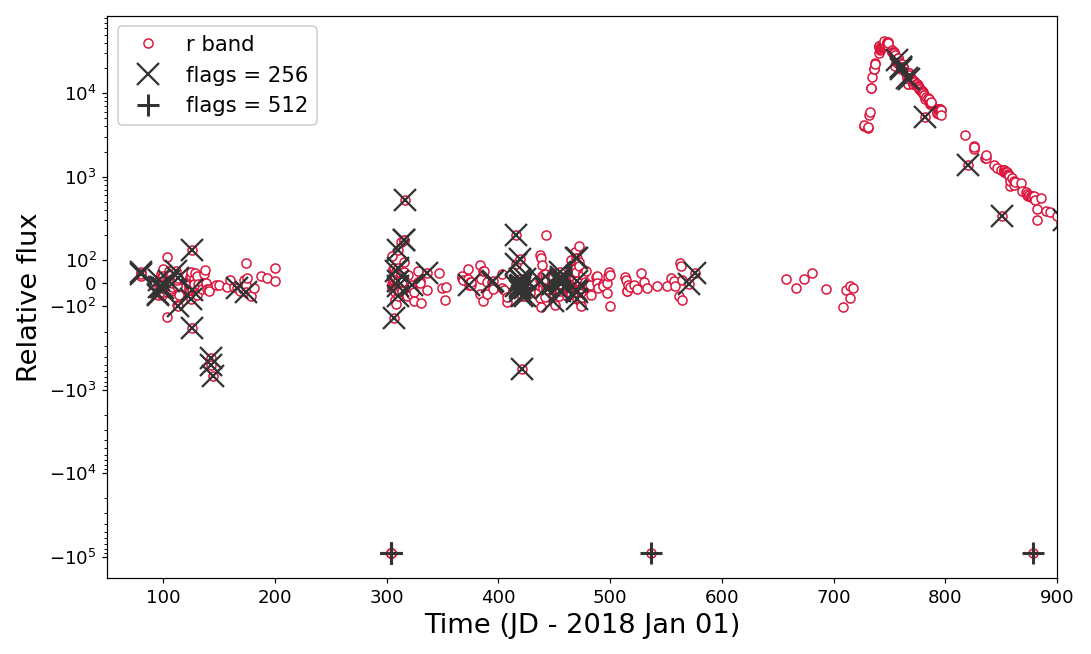

In [6]:
fp_df = calibrate_fps.read_ipac_fps('../fps_data/ZTF19adcecwu.txt')

jdstart = 2458119.5 # 2018 Jan 01
t_peak = 2458862.4618663252
r_band = np.where(fp_df.fcqfid.values == 8191332)

bad_obs = np.where((fp_df.fcqfid.values == 8191332) &
                   ( (fp_df.infobitssci.values != 0)
                   )
                  )

no_output = np.where((fp_df.fcqfid.values == 8191332) &
                   ( (fp_df.forcediffimfluxunc.values < -99998)
                   )
                  )

roll_med = fp_df.iloc[r_band].forcediffimflux.rolling('14D', center=True).median().values


fig, ax = plt.subplots(figsize=(10,6))


ax.plot(fp_df.jd.values[r_band] - jdstart, 
        fp_df.forcediffimflux.values[r_band],
        'o', mec='Crimson', mfc='white', 
        label='r band')

ax.plot(fp_df.jd.values[bad_obs] - jdstart, 
        fp_df.forcediffimflux.values[bad_obs],
        'x', ms=14, mec='0.2', mew=1.5,
        label='flags = 256')

ax.plot(fp_df.jd.values[no_output] - jdstart, 
        fp_df.forcediffimflux.values[no_output],
        '+', ms=14, mec='0.2', mew=2,
        label='flags = 512')


ax.set_xlim(50, 900)
ax.set_yscale('symlog', 
              linthresh=100, 
              linscale=0.25, 
              subs=[2, 3, 4, 5, 6, 7, 8, 9])
ax.legend(loc=2, fontsize=14, framealpha=1)

ax.set_ylabel('Relative flux', fontsize=18)
ax.set_xlabel('Time (JD - 2018 Jan 01)', fontsize = 18)
ax.tick_params(axis='both', labelsize=12)
fig.tight_layout()
fig.savefig('../images/flagged_obs.jpg')

### Time of maximum

For individual transients we determine the time of maximum by calculating a running median with a 14 day window for every field + filter + chip + quadrant combination (designated `fcqfid` see [Yao et al. (2019)](http://dx.doi.org/10.3847/1538-4357/ab4cf5)) in the fps products. The final time of maximum is determined by taking the mean time of maximum for any g-band or r-band fcqfids taken on the primary ZTF observing grid (see [Bellm et al. (2018)](http://dx.doi.org/10.1088/1538-3873/aaecbe) for more details on the primary and secondary ZTF observing grids).

### Baseline correction
By default, the baseline for each `fcqfid` is determined using observations obtained more than *100 d prior* to the time of maximum light and long after the transient has faded below the ZTF detection threshold. This time is (conservatively) determined by assuming the peak luminosity of the transient is purely powered by radioactive $^{56}$Co, and we then calculate the time to fade to 22.5 mag in the observed frame assuming the transient is at z = 0.09 (this choice of redshift is conservative). The baseline correction `C` is calculated via the median `forcediffimflux` value in the baseline region, and uncertainty of the baseline `C` is obtained using bootstrapping.

We report the total number of observations used to calculate `C` and whether the baseline is measured in observations before, after, or before and after the maximum light. We advise caution when using light curves with few baseline observations (< ~25), and do not provide baseline corrections when there are < 2 observations in the baseline region. If there are pre-maximum light or post-maximum light emission in the baseline, we provide "long rise" or "long decline" warning respectively. If both pre- and post- maximum light emissions are present, a "bad baseline" warning is given.

<IPython.core.display.Javascript object>


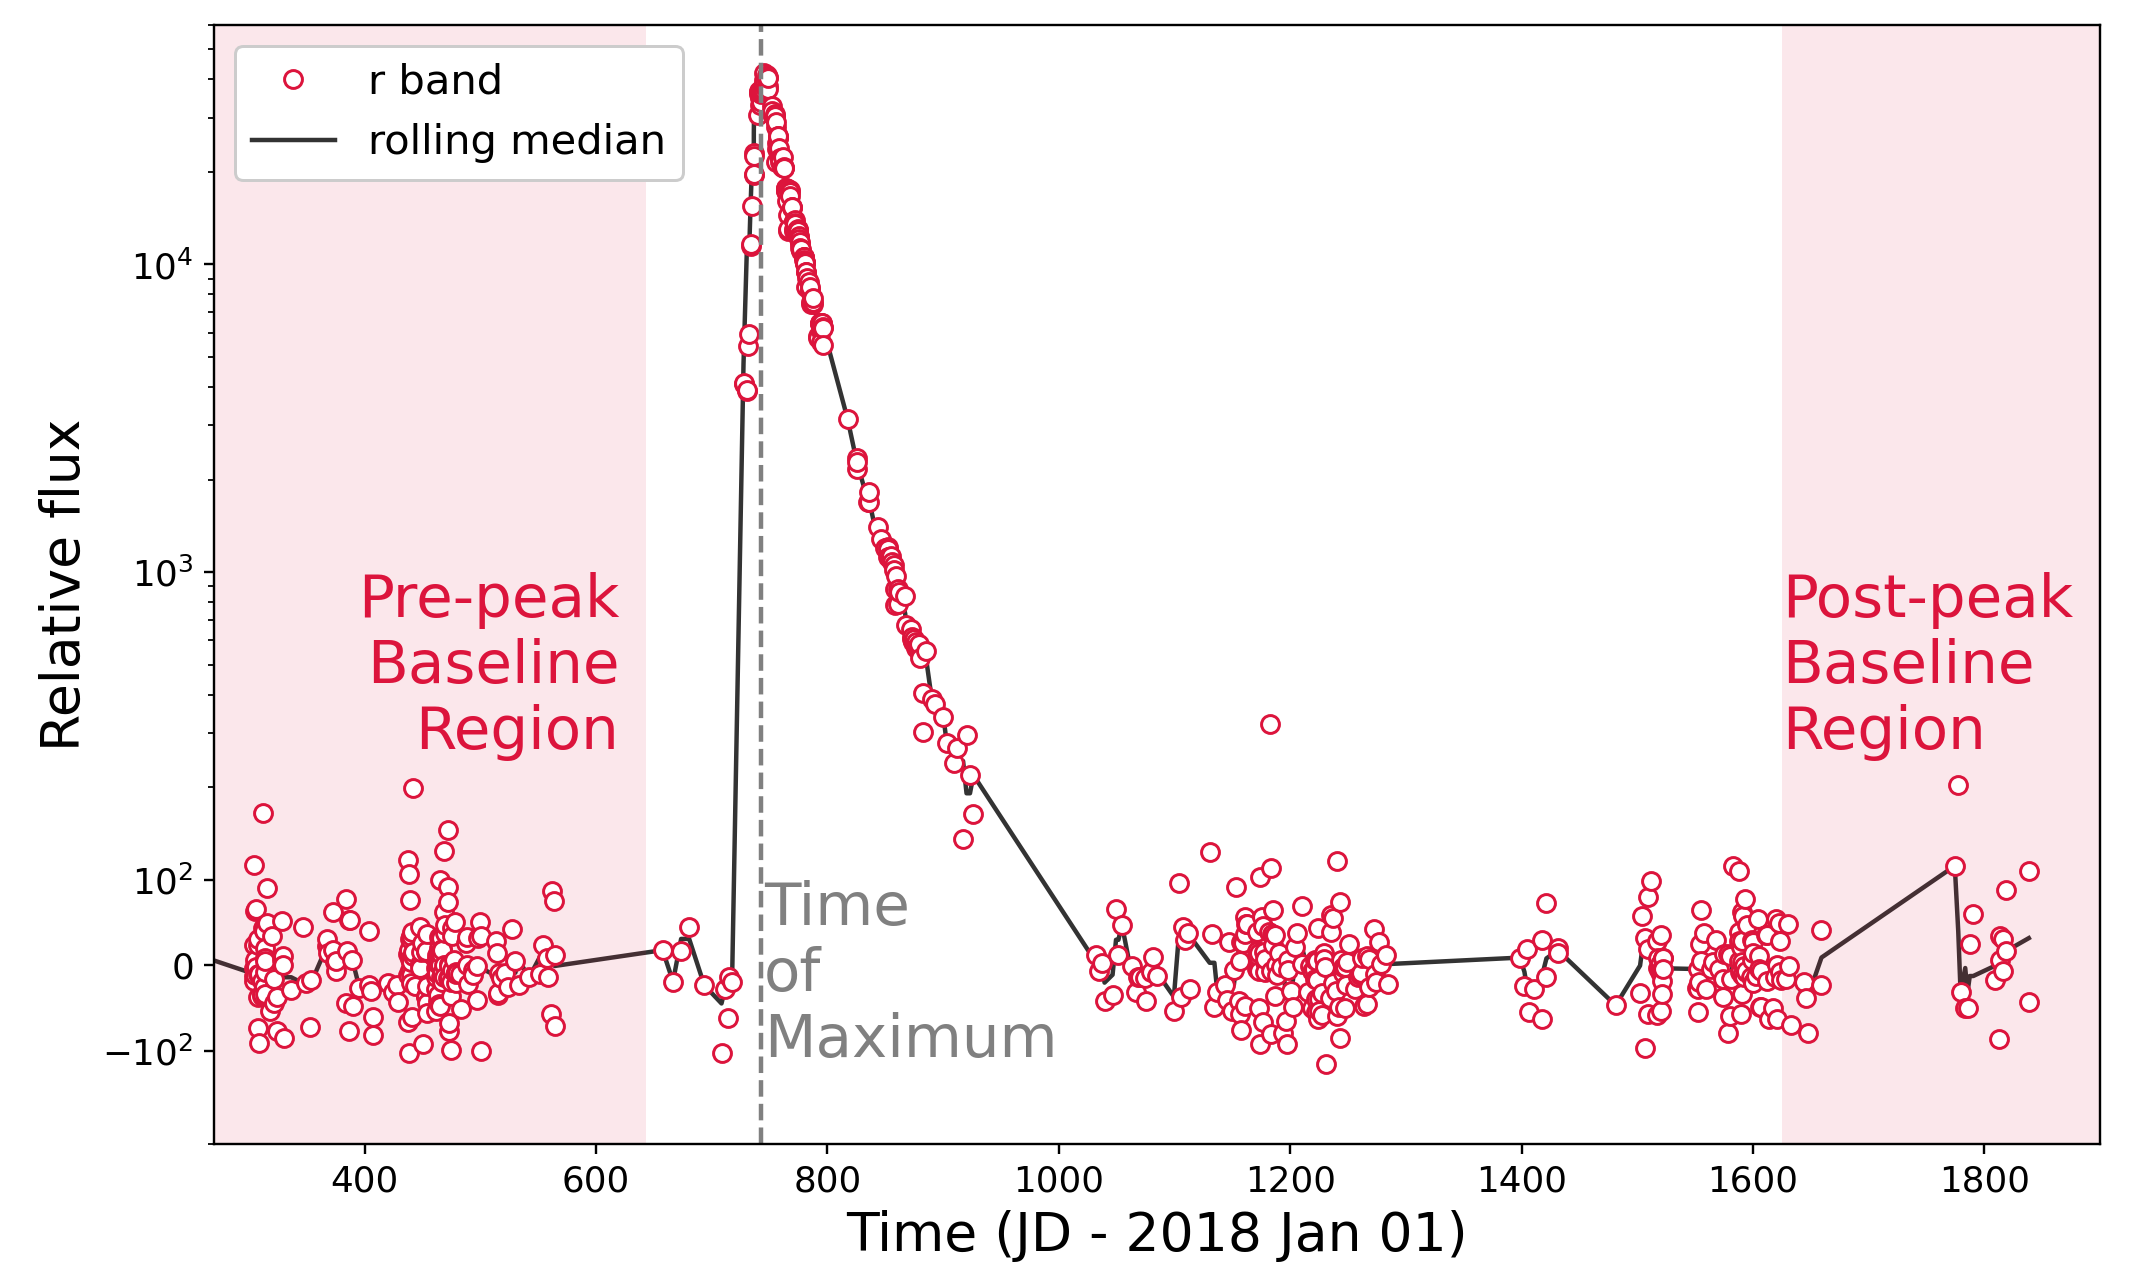

In [28]:
fp_df = calibrate_fps.read_ipac_fps('../fps_data/ZTF19adcecwu.txt')

# make a plot showing baseline detection
jdstart = 2458119.5 # 2018 Jan 01
t_peak = 2458862.4618663252
r_band = np.where((fp_df.fcqfid.values == 8191332) & 
                  (fp_df.infobitssci.values == 0) & 
                  (fp_df.forcediffimfluxunc.values > -99998)
                 )

around_max = np.where((fp_df.jd.values - t_peak > - 10) &
                      (fp_df.jd.values - t_peak < 10) & 
                      (fp_df.forcediffimflux.values > 0))
if len(around_max[0]) > 0:
    diff_flux_around_max = fp_df.forcediffimflux.values[around_max]
    mag_min = np.nanmin(fp_df.zpdiff.values[around_max] -
                        2.5*np.log10(diff_flux_around_max))
    #calculate time when SN signal is "gone" via Co56 decay at z ~ 0.09
    t_faded = t_peak + (22.5 - mag_min)/0.009



roll_med = fp_df.iloc[r_band].forcediffimflux.rolling('14D', center=True).median().values


fig, ax = plt.subplots(figsize=(10,6))


ax.plot(fp_df.jd.values[r_band] - jdstart, 
        fp_df.forcediffimflux.values[r_band],
        'o', mec='Crimson', mfc='white', 
        label='r band')

ax.plot(fp_df.jd.values[r_band] - jdstart, 
        roll_med, color='0.2', 
        label='rolling median', zorder=-10)


ax.axvline(x = t_peak - jdstart, 
           color = '0.5', ls = '--')
ax.axvspan(0, t_peak - jdstart - 100, color='Crimson', alpha=0.1, lw=0)

ax.axvspan(t_faded - jdstart, 2500, color='Crimson', alpha=0.1, lw=0)


ax.set_xlim(270, 1900)
ax.set_ylim(-200,6e4)
ax.set_yscale('symlog', 
              linthresh=100, 
              linscale=0.25, 
              subs=[2, 3, 4, 5, 6, 7, 8, 9])
ax.legend(loc=2, fontsize=14, framealpha=1)
ax.text(620, 1e3, 'Pre-peak\nBaseline\nRegion', 
        ha='right',va='top',
        fontsize=20, color='Crimson')
ax.text(1625, 1e3, 'Post-peak\nBaseline\nRegion', 
        ha='left',va='top',
        fontsize=20, color='Crimson')
ax.text(t_peak - jdstart+2, 1e2, 'Time\nof\nMaximum', 
        ha='left',va='top',
        fontsize=20, color='0.5')
ax.set_ylabel('Relative flux', fontsize=18)
ax.set_xlabel('Time (JD - 2018 Jan 01)', fontsize = 18)
ax.tick_params(axis='both', labelsize=12)
fig.subplots_adjust(right=0.98, left=0.1, top=0.98)
# fig.tight_layout()
fig.savefig('../images/baseline_max.jpg')

### Scaling the uncertainties

Following the recommendation in the [fps documentation](http://web.ipac.caltech.edu/staff/fmasci/ztf/forcedphot.pdf), we re-scale the uncertainties of all observations based on the chi-squared distribution of observations in the baseline region. In brief, flux measurements in an "empty" patch of sky should follow a Gaussian distribution and "excess" scatter points to some systematic uncertainty that has not been properly quantified (subtractions near galaxy nuclei often exhibit such excess scatter). If the mean of the chi-squared distribution is < 1.5, then the uncertainties *of all observations* are multiplied by the square root of the median chi-squared distribution in the baseline region. Otherwise, if there are "good observations" (`infobits` = 0, see above), a [SuperSmoother](https://github.com/jakevdp/supersmoother/) model is used to obtain a smooth fit of chi-squared distribution as function of flux of these "good observations". The chi-squared distribution for the "bad observations" (`infobits` > 0) are obtained by interpolating the chi-squared distributions of the "good observations". In case the model fails, 1000s rolling medians on the "good observations" are used for the interpolation. The uncertainties *of all observations* are then multiplied by the square root of all the interpolated chi-squared distributions (see also [Yao et al. (2019)](http://dx.doi.org/10.3847/1538-4357/ab4cf5)).

In [45]:
fp_df.zpmaginpscirms

2018-03-21 08:56:06.996476    0.029264
2018-03-22 06:03:10.995826    0.060563
2018-03-22 06:05:57.998380    0.050380
2018-03-22 06:37:52.000310    0.025892
2018-03-22 06:39:14.996158    0.027129
                                ...   
2023-01-28 11:18:11.998073    0.032188
2023-02-04 07:19:34.999689    0.040637
2023-02-04 09:18:44.003519    0.031711
2023-02-04 11:24:40.996808    0.035458
2023-02-05 09:43:56.003526    0.038267
Name: zpmaginpscirms, Length: 3994, dtype: float64

<IPython.core.display.Javascript object>


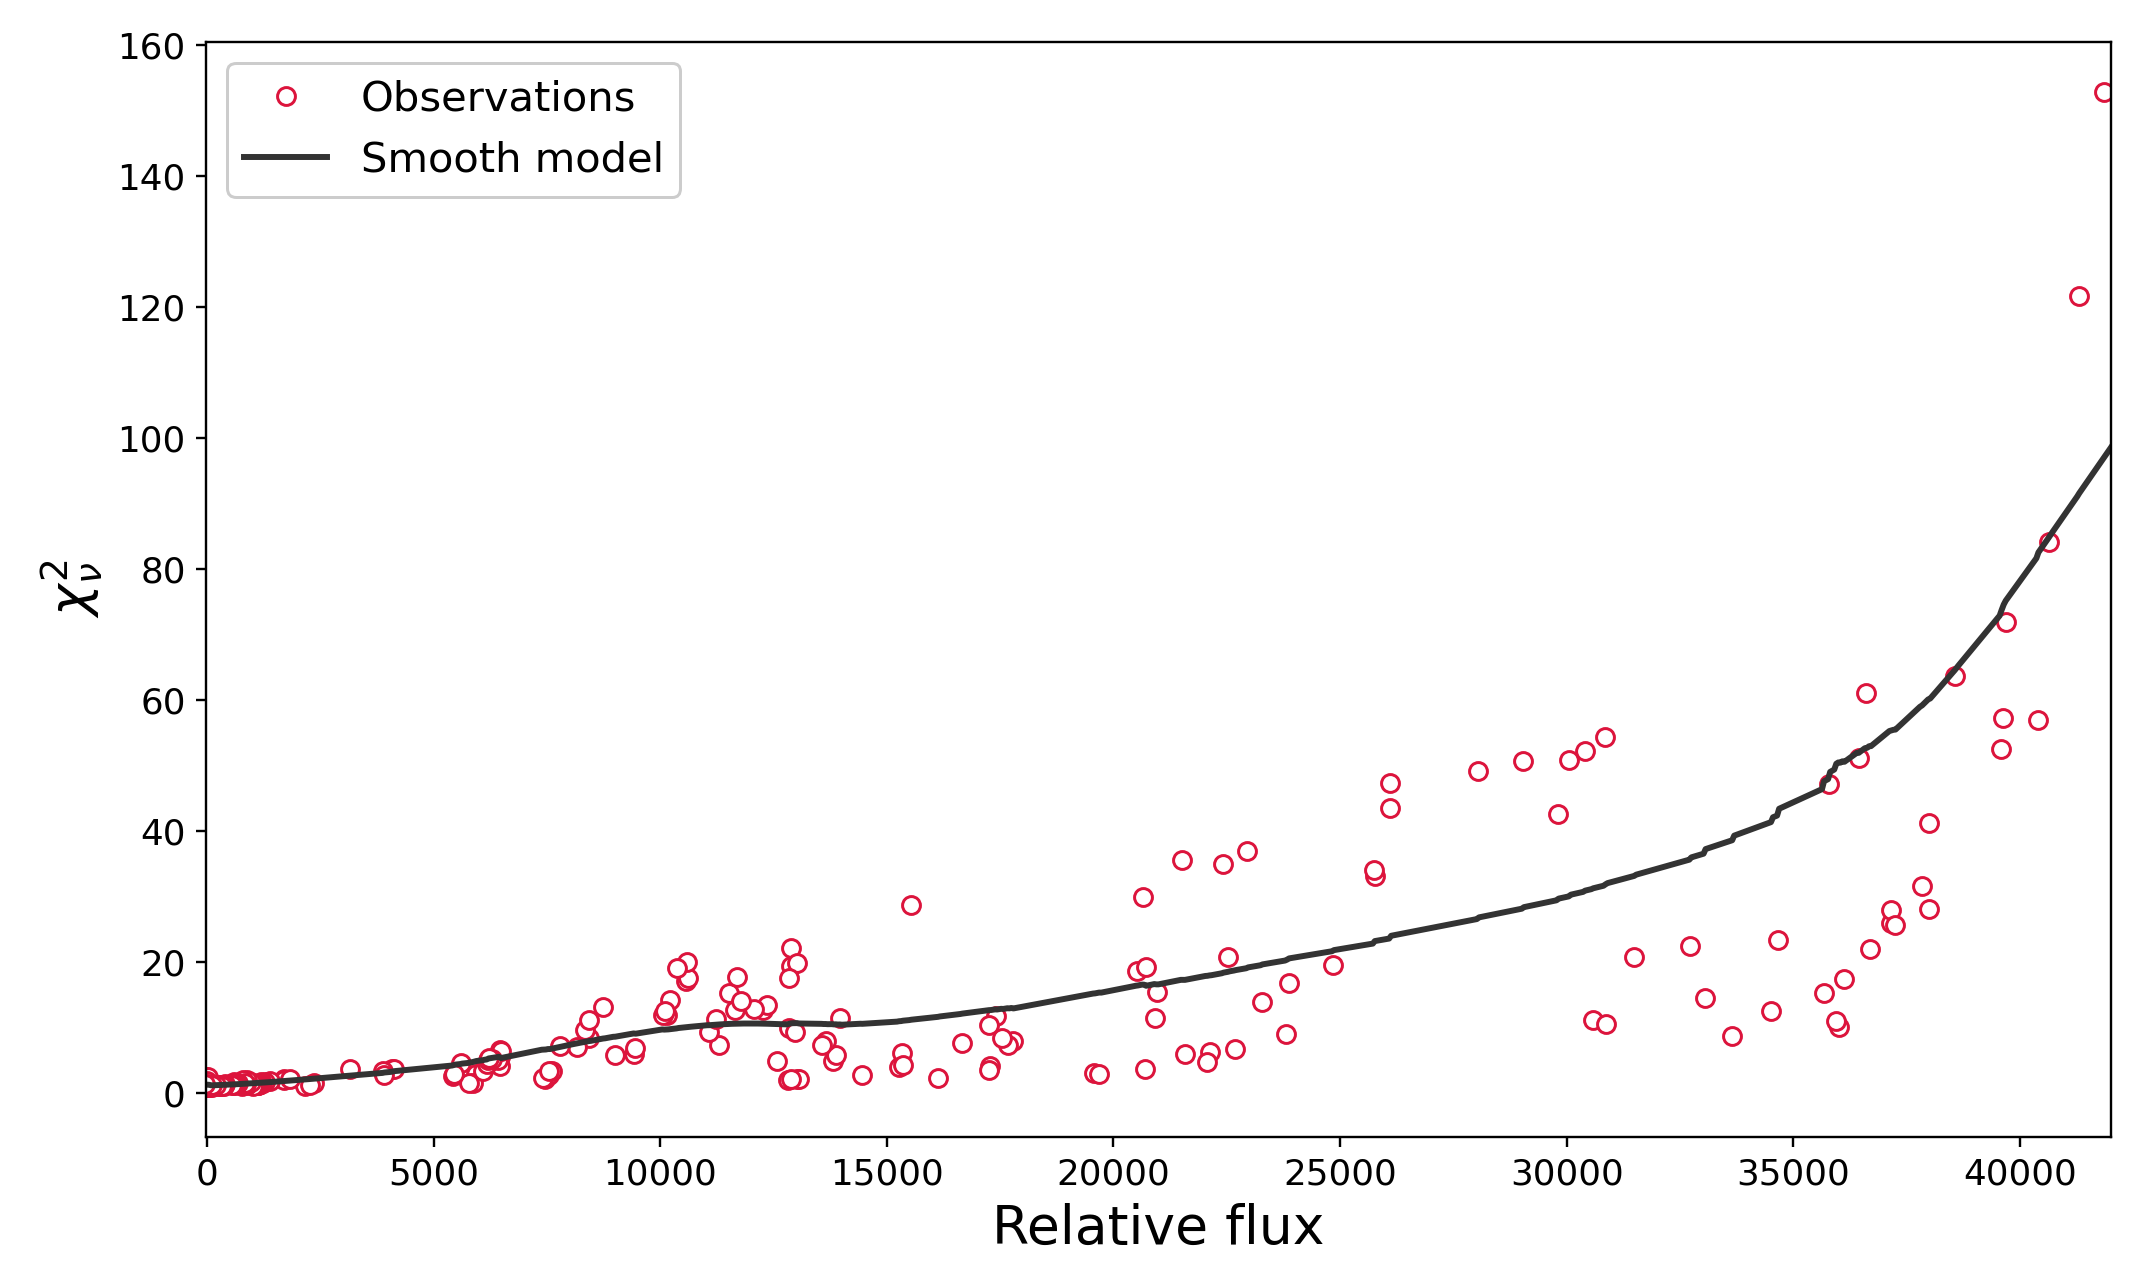

In [40]:
from supersmoother import SuperSmoother

fp_df = calibrate_fps.read_ipac_fps('../fps_data/ZTF19adcecwu.txt')

# make a plot showing baseline detection
jdstart = 2458119.5 # 2018 Jan 01
t_peak = 2458862.4618663252
r_band = np.where((fp_df.fcqfid.values == 8191332) & 
                  (fp_df.infobitssci.values == 0) & 
                  (fp_df.forcediffimfluxunc.values > -99998)
                 )

model = SuperSmoother()
model.fit(fp_df.forcediffimflux.iloc[r_band], 
          fp_df.forcediffimchisq.iloc[r_band])
# find the smoothed fit to the data
# interpolate to non-good obs
yfit = model.predict(np.sort(fp_df.forcediffimflux.iloc[r_band])) 
x_grid = np.linspace(0,45000,1000)
yfit = model.predict(x_grid) 


fig, ax = plt.subplots(figsize=(10,6))

ax.plot(fp_df.forcediffimflux.iloc[r_band], 
        fp_df.forcediffimchisq.iloc[r_band], 
        'o', color='Crimson', mfc='white',
       label='Observations')

ax.plot(x_grid, yfit, lw=2, color='0.2',
        label='Smooth model')

ax.set_xlabel('Relative flux', fontsize=18)
ax.set_ylabel(r'$\chi^2_\nu$', fontsize = 18)
ax.tick_params(axis='both', labelsize=12)
ax.legend(loc=2, fontsize=14, framealpha=1)

ax.set_xlim(-10,42000)
fig.tight_layout()
fig.savefig('../images/flux_dependent_scaling.jpg')

<IPython.core.display.Javascript object>


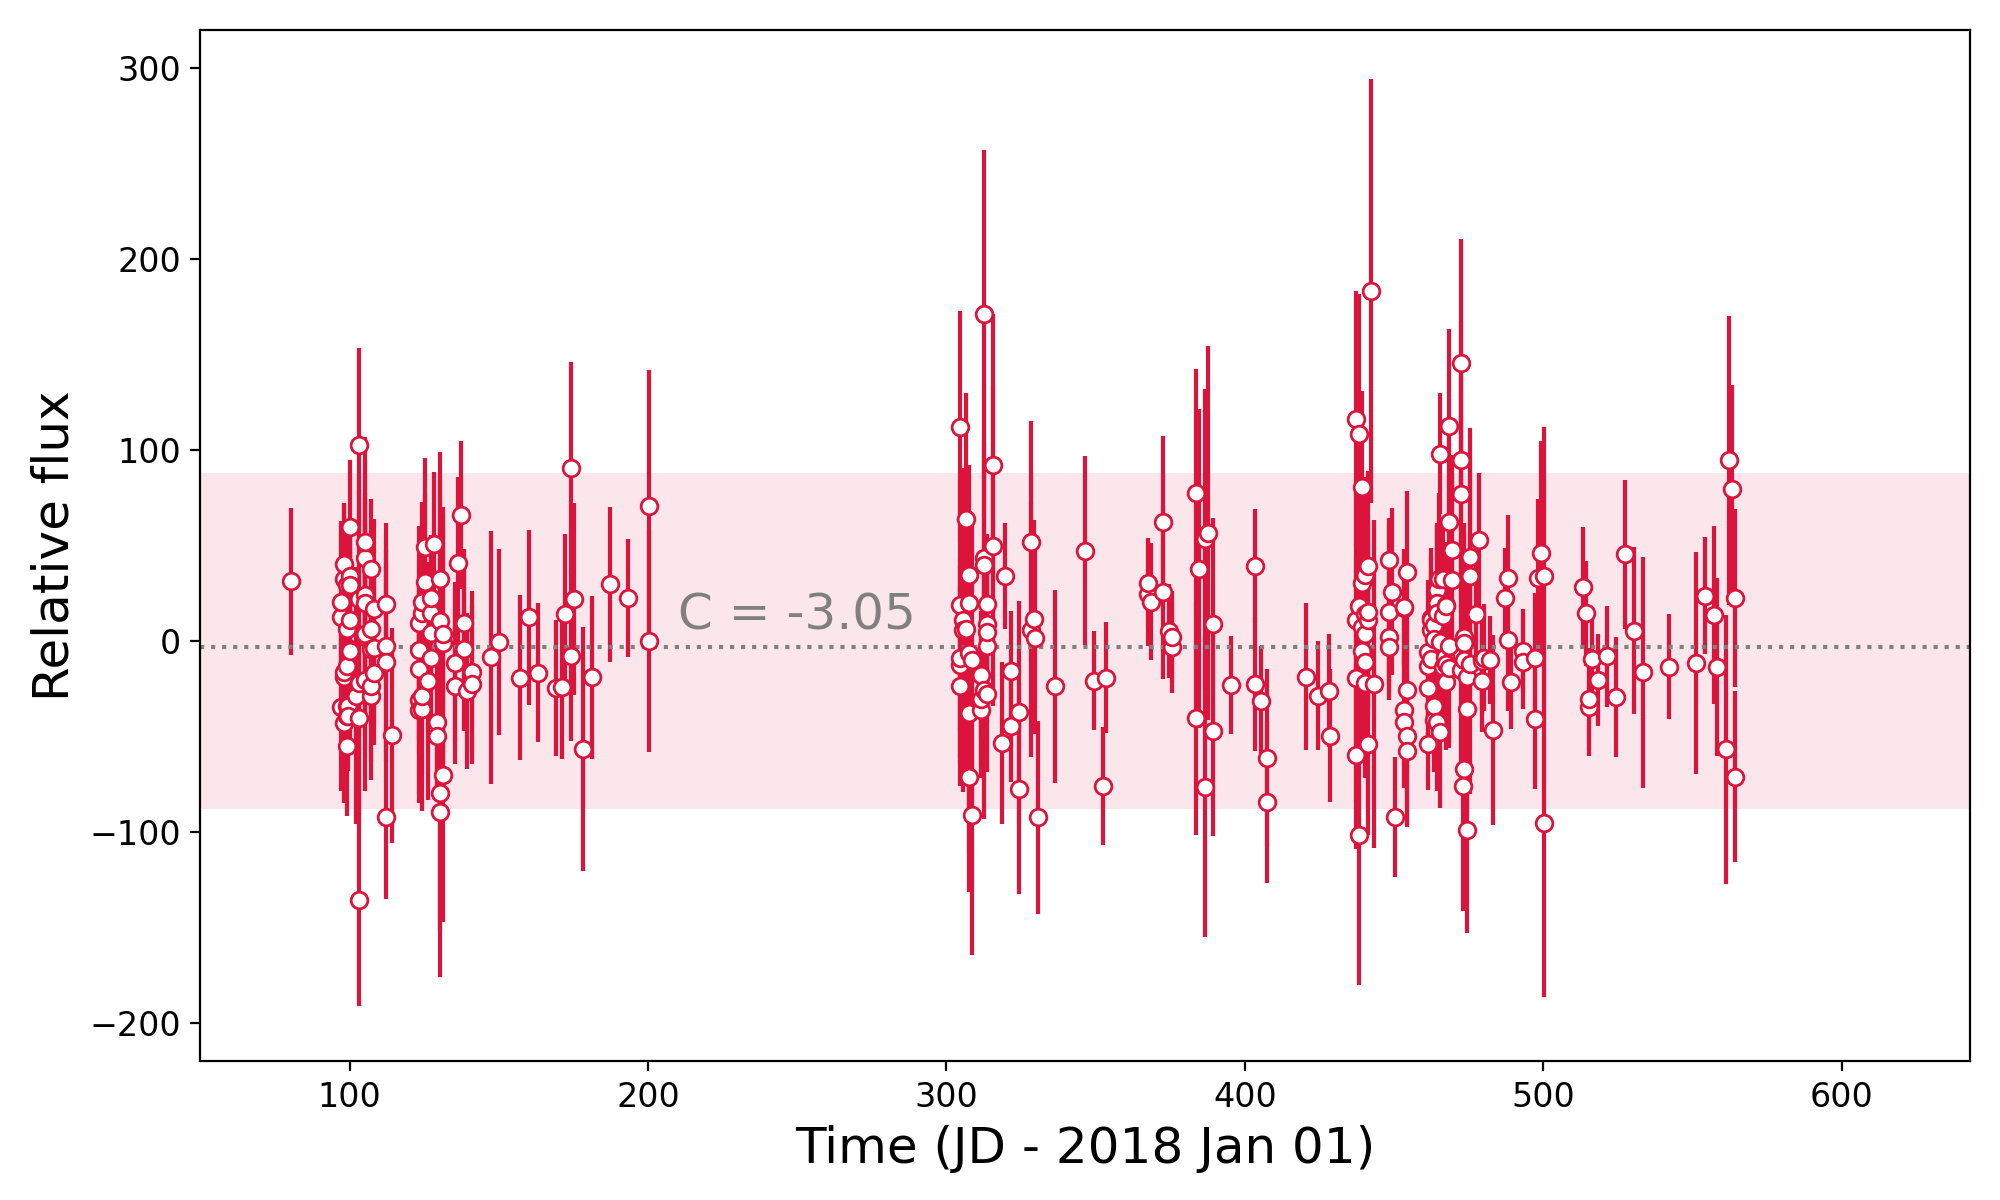

In [4]:
fp_df = calibrate_fps.read_ipac_fps('./fps_data/forcedphotometry_ZTF19adcecwu_lc.txt.gz')

# make a plot showing baseline detection
jdstart = 2458119.5 # 2018 Jan 01
t_peak = 2458862.4618663252
r_baseline = np.where((fp_df.fcqfid.values == 8191332) &
                      (t_peak - fp_df.jd.values > 100) & 
                      (fp_df.infobitssci.values == 0) & 
                      (fp_df.scisigpix.values < 25) & 
                      (fp_df.sciinpseeing.values < 5)
                     )

fig, ax = plt.subplots(figsize=(10,6))


ax.errorbar(fp_df.jd.values[r_baseline] - jdstart, 
            fp_df.forcediffimflux.values[r_baseline],
            fp_df.forcediffimfluxunc.values[r_baseline],
            fmt='o', mec='Crimson', mfc='white', ecolor='Crimson',
            label='r band')

# calculate baseline and scatter
Cmean = np.average(fp_df.forcediffimflux.values[r_baseline], 
                   weights=1/fp_df.forcediffimfluxunc.values[r_baseline]**2)
sum_diff_sq = np.sum( ( (fp_df.forcediffimflux.values[r_baseline] - Cmean) / 
                        (fp_df.forcediffimfluxunc.values[r_baseline])
                      )**2
                    )
chi = 1/(len(fp_df.jd.values[r_baseline])-1)*sum_diff_sq


ax.axvline(x = t_peak - jdstart, 
           color = '0.5', ls = ':')
ax.axhline(y = Cmean, color='0.5', ls =':')
ax.axhspan(-2*np.std(fp_df.forcediffimflux.values[r_baseline]), 
           2*np.std(fp_df.forcediffimflux.values[r_baseline]),
           color='Crimson', alpha=0.1, lw=0)

ax.set_xlim(50, 642.96)
ax.set_ylim(-220,320)
ax.text(250, 1, 'C = {:.2f}'.format(Cmean), 
        ha='center',va='bottom',
        fontsize=18, color='0.5')
ax.set_ylabel('Relative flux', fontsize=18)
ax.set_xlabel('Time (JD - 2018 Jan 01)', fontsize = 18)
ax.tick_params(axis='both', labelsize=12)
fig.tight_layout()
fig.savefig('./images/scale_uncertainties.jpg')



### Calibrated fluxes

To produce the final calibrated flux measurements, the baseline value `C` is subtracted from all flux measurements `forcediffimflux`. The uncertainties are scaled (see above), and the flux in microJy is calculated as:

<img src="https://render.githubusercontent.com/render/math?math=\Large f_\nu = 10^{29 - 48.6/2.5 - 0.4*\mathrm{zpdiff}*(\mathrm{forcediffimflux} - C)}">


## Final product

The final output from this procedure includes a csv file `ZTFYYnnnnnnn_fnu.csv` with nine columns:

1. JD - Julian date of the observation
2. fnu_microJy - the flux in microJy
3. fnu_microJy_unc - the uncertainty on the flux in microJy
4. passband - the filter of the observations (ZTF_g, ZTF_r, or ZTF_i)
5. programid - Program identifier (0 = engineering; 1 = public; 2 = private; 3 = Caltech time) ([see IPAC fps documentation](http://web.ipac.caltech.edu/staff/fmasci/ztf/forcedphot.pdf))
6. fcqfid - field + filter + ccd + quadrant combination (see above)
7. zpdiff - photometric zeropoint for difference image
8. sys_unc_factor - systematic uncertainty used for scaling (see above)
9. poor_conditions - =1 if the observation is unreliable (see above)